In [726]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [727]:
# ATENCION /.\: Puede que no lea el csv si hay comas entre nombres de transportistas, etc (ELIMINAR LAS COMAS PRIMERO)
ruta = pd.read_csv('rechazos_ruta.csv')
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Subregion Comercial         8104 non-null   object 
 1   Locación                    8104 non-null   object 
 2   Ruta Troncal Dinámico       8104 non-null   object 
 3   Ruta Figura Dinámico        8104 non-null   object 
 4   Sistema de Ventas Dinámico  8104 non-null   object 
 5   Supervisor                  6875 non-null   object 
 6   VendedorCod                 8104 non-null   int64  
 7   Motivo de anulación         8104 non-null   object 
 8   Número de Pedido            8104 non-null   int64  
 9   Número de orden de carga    8094 non-null   float64
 10  Número de Guía              8104 non-null   int64  
 11  Semana                      8104 non-null   int64  
 12  Mes                         8104 non-null   object 
 13  Año                         8104 

In [728]:
# eliminar todas las columnas excepto las relevantes
ruta = ruta[[
    'Locación',
    'Ruta Troncal Dinámico',
    'Motivo de anulación',
    'Día',
    'Venta Perdida CF',
    'Cliente',
    'Transportista',
    'Nombre Vendedor',
]]
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8104 non-null   object 
 1   Ruta Troncal Dinámico  8104 non-null   object 
 2   Motivo de anulación    8104 non-null   object 
 3   Día                    8104 non-null   object 
 4   Venta Perdida CF       8104 non-null   float64
 5   Cliente                8104 non-null   object 
 6   Transportista          8104 non-null   object 
 7   Nombre Vendedor        8104 non-null   object 
dtypes: float64(1), object(7)
memory usage: 506.6+ KB
None


In [729]:
# conservar las filas que contenga las siguientes Locaciones (por si acaso lo normal es que no esten estas locaciones)
locaciones = ['06 AYA EL PEDREGAL', '38 AYA ATICO', '40 AYA CHALA', '88 AYA CAMANA']
ruta = ruta[ruta['Locación'].isin(locaciones)]
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8104 non-null   object 
 1   Ruta Troncal Dinámico  8104 non-null   object 
 2   Motivo de anulación    8104 non-null   object 
 3   Día                    8104 non-null   object 
 4   Venta Perdida CF       8104 non-null   float64
 5   Cliente                8104 non-null   object 
 6   Transportista          8104 non-null   object 
 7   Nombre Vendedor        8104 non-null   object 
dtypes: float64(1), object(7)
memory usage: 506.6+ KB
None


In [730]:
# rellenar los valores NaN con 0
ruta = ruta.fillna(0)
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8104 non-null   object 
 1   Ruta Troncal Dinámico  8104 non-null   object 
 2   Motivo de anulación    8104 non-null   object 
 3   Día                    8104 non-null   object 
 4   Venta Perdida CF       8104 non-null   float64
 5   Cliente                8104 non-null   object 
 6   Transportista          8104 non-null   object 
 7   Nombre Vendedor        8104 non-null   object 
dtypes: float64(1), object(7)
memory usage: 506.6+ KB
None


# ANALISIS
### Consignar tiempo a analizar

In [731]:
''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por Año (Escoger el año especifico) (Analisis de todo ese año)
(2) Por Mes (Escoger el mes especifico) (Analisis de todo ese mes)
(3) Por Día (Escoger el día especifico) (Analisis de todo ese día)
(4) Intervalo (Escoger fecha de inicio y fecha de fin especificas) (Analisis de todo el intervalo considerando las fechas ingresadas)
(5) Mayor igual que (Escoger fecha de inicio) (Analisis considerando esa fecha hasta el ultimo registro existente)
'''
# Establecer dia como tipo fecha
ruta['Día'] = pd.to_datetime(ruta['Día'], errors='coerce', dayfirst=True)

# Seleccionar la opcion_tiempo de análisis por tiempo
opcion_tiempo = int(input("(1=Año) (2=Mes) (3=Dia) (4=Intervalo) (5=Mayor igual que)"))
fecha = 0

if opcion_tiempo == 1:
    fecha = input("año")
    fecha_inicio = pd.to_datetime('01/01/'+str(fecha), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime('31/12/'+str(fecha), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] <= fecha_fin)]
elif opcion_tiempo == 2:
    fecha = input("mes/año")
    month, year = fecha.split('/')
    fecha_inicio = pd.to_datetime('01/'+str(month)+'/'+str(year), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime('01/'+str(int(month)+1)+'/'+str(year), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] < fecha_fin)]
elif opcion_tiempo == 3:
    fecha = input("dia/mes/año")
    fecha_corte = pd.to_datetime(str(fecha), format='%d/%m/%Y')
    ruta = ruta[ruta['Día'] == fecha_corte]
elif opcion_tiempo == 4:
    fecha = input("dia/mes/año dia/mes/año")
    fecha_inicio, fecha_fin = fecha.split(' ')
    fecha_inicio = pd.to_datetime(str(fecha_inicio), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime(str(fecha_fin), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] <= fecha_fin)]
elif opcion_tiempo == 5:
    fecha = input("dia/mes/año")
    fecha_corte = pd.to_datetime(str(fecha), format='%d/%m/%Y')
    ruta = ruta[ruta['Día'] >= fecha_corte]

print(ruta.info())

C:\Users\AYACDA23\AppData\Local\Temp\ipykernel_13780\1871147092.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ruta['Día'] = pd.to_datetime(ruta['Día'], errors='coerce', dayfirst=True)


<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 8009 to 8046
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Locación               38 non-null     object        
 1   Ruta Troncal Dinámico  38 non-null     object        
 2   Motivo de anulación    38 non-null     object        
 3   Día                    38 non-null     datetime64[ns]
 4   Venta Perdida CF       38 non-null     float64       
 5   Cliente                38 non-null     object        
 6   Transportista          38 non-null     object        
 7   Nombre Vendedor        38 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 2.7+ KB
None


### MOTIVO DE ANULACION

In [732]:
# Venta perdida por motivo de anulación
#motivos_vp = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)
#motivos_vp.plot(kind='bar', title='Cantidad de venta perdida por motivo')

def vp_motivo_anulacion():
    try:
        # Agrupar y ordenar
        motivos_vp = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        bars = motivos_vp.plot(
            kind='bar',
            title='Venta Perdida por Motivo',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_motivos = 0
        # Agregar valores exactos encima de cada barra
        for i, value in enumerate(motivos_vp.values):
            total_vp_motivos = total_vp_motivos + value
            ax.text(
                i, value + (value * 0.01),  # posición X, Y
                f'{value:,.0f}$',            # formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico (opcional)
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_motivos, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [733]:
# Veces rechazadas por motivo de anulación
# ruta['Motivo de anulación'].value_counts().plot(kind='bar', title='Top motivos de anulación')

def vr_motivo_anulacion():
    try:
        # Obtener los datos
        motivos_counts = ruta['Motivo de anulación'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = motivos_counts.plot(
            kind='bar',
            title='Veces rechazadas por motivo de anulación',
            ax=ax,
            figsize=(10, 8)
        )

        total_motivos = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(motivos_counts.values):
            total_motivos = total_motivos + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_motivos)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [734]:
# Venta perdida y rechazos por Motivo de anulacion

def vp_vr_motivo_anulacion():
    try:
        group = ruta.groupby('Motivo de anulación')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        motivos = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[motivos]
        cantidad = cantidad[motivos]

        # Preparar posiciones
        x = np.arange(len(motivos))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Motivo (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(motivos, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Motivos')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [735]:
# Venta perdida porcentual por motivo de anulación

def vp_porcentual_motivo_anulacion():
    try:
        # Agrupar y ordenar por venta perdida
        vp_motivo_anulacion = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los 10 principales motivos de anulacion si el analisis es anual
        # vp_motivo_anulacion = vp_motivo_anulacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_motivo_anulacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los motivos de anulación
        ax.legend(
            wedges,
            vp_motivo_anulacion.index,
            title='Motivo de anulación',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Motivo de Anulación')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [736]:
# Veces rechazadas porcentual por motivo de anulación

def vr_porcentual_motivo_anulacion():
    try:
        # Obtener los datos
        vr_motivo_anulacion = ruta['Motivo de anulación'].value_counts()

        # (Opcional) Limitar a los 10 principales motivos de anulacion si el analisis es anual
        # vr_motivo_anulacion = vr_motivo_anulacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_motivo_anulacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los motivos de anulación
        ax.legend(
            wedges,
            vr_motivo_anulacion.index,
            title='Motivo de anulación',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Veces rechazadas por Motivo de Anulación')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### TRANSPORTISTA

In [737]:
# Venta perdida por transportista
# ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False).plot(kind='bar', title='Venta Perdida por Transportista')

def vp_transportista():
    try:
        # Agrupar y ordenar
        vp_transportista = ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vp_transportista.plot(
            kind='bar',
            title='Venta Perdida por Transportista',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_transportista = 0
        # Agregar valores exactos encima de cada barra
        for i, value in enumerate(vp_transportista.values):
            total_vp_transportista = total_vp_transportista + value
            ax.text(
                i, value + (value * 0.01),       # posición Y: ligeramente arriba de la barra
                f'{value:,.0f}$',                 # formato: separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico (opcional)
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_transportista, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [738]:
# Veces rechazadas por transportista

def vr_transportista():
    try:
        # Obtener los datos
        transportista_counts = ruta['Transportista'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = transportista_counts.plot(
            kind='bar',
            title='Veces rechazadas por transportista',
            ax=ax,
            figsize=(10, 8)
        )

        total_transportista = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(transportista_counts.values):
            total_transportista = total_transportista + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_transportista)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [739]:
# Venta perdida y rechazos por Transportista

def vp_vr_transportista():
    try:
        group = ruta.groupby('Transportista')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        transportistas = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[transportistas]
        cantidad = cantidad[transportistas]

        # Preparar posiciones
        x = np.arange(len(transportistas))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Transportista (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(transportistas, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Transportista')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [740]:
# Venta perdida porcentual por motivo de transportista

def vp_porcentual_transportista():
    try:
        # Agrupar y ordenar por venta perdida
        vp_transportista = ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los 10 principales transportistas si el analisis es anual
        # vp_transportista = vp_transportista.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_transportista,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los transportistas
        ax.legend(
            wedges,
            vp_transportista.index,
            title='Transportista',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Transportista')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [741]:
# Veces rechazadas porcentual por transportista

def vr_porcentual_transportista():
    try:
        # Obtener los datos
        vr_transportista = ruta['Transportista'].value_counts()

        # (Opcional) Limitar a los 10 principales transportista si el analisis es anual
        # vr_transportista = vr_transportista.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_transportista,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los transportistas
        ax.legend(
            wedges,
            vr_transportista.index,
            title='Transportista',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Veces rechazadas por Transportista')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### RUTA TRONCAL

In [742]:
# Venta perdida por ruta
# ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False).plot(kind='bar', title='Venta Perdida por Ruta')

def vp_ruta():
    try:
        # Agrupar y ordenar por venta perdida
        vp_ruta = ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vp_ruta.plot(
            kind='bar',
            title='Venta Perdida por Ruta',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_ruta = 0
        # Agregar etiquetas con valores exactos
        for i, value in enumerate(vp_ruta.values):
            total_vp_ruta = total_vp_ruta + value
            ax.text(
                i, value + (value * 0.01), # Y: un poco arriba de la barra
                f'{value:,.0f}$',           # formato con separadores de miles
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_ruta, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [743]:
# Veces rechazadas por ruta

def vr_ruta():
    try:
        # Obtener los datos
        ruta_counts = ruta['Ruta Troncal Dinámico'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = ruta_counts.plot(
            kind='bar',
            title='Veces rechazadas por ruta',
            ax=ax,
            figsize=(10, 8)
        )

        total_ruta = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(ruta_counts.values):
            total_ruta = total_ruta + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_ruta)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [744]:
# Venta perdida y cantidad por Ruta

def vp_vr_ruta():
    try:
        group = ruta.groupby('Ruta Troncal Dinámico')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        rutas = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[rutas]
        cantidad = cantidad[rutas]

        # Preparar posiciones
        x = np.arange(len(rutas))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Ruta (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(rutas, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Ruta')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [745]:
# Venta perdida porcentual por ruta

def vp_porcentual_ruta():
    try:
        # Agrupar y ordenar por venta perdida
        vp_ruta = ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a las 10 principales rutas si el analisis es anual
        # vp_ruta = vp_ruta.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_ruta,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de las rutas
        ax.legend(
            wedges,
            vp_ruta.index,
            title='Ruta Troncal',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Ruta')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [746]:
# Veces rechazadas porcentual por ruta

def vr_porcentual_ruta():
    try:
        # Obtener los datos
        vr_ruta = ruta['Ruta Troncal Dinámico'].value_counts()

        # (Opcional) Limitar a las 10 principales rutas si el analisis es anual
        # vr_ruta = vr_ruta.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_ruta,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de las rutas
        ax.legend(
            wedges,
            vr_ruta.index,
            title='Ruta',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Veces rechazadas por Ruta')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### CLIENTE

In [747]:
# Venta perdida por cliente
# clientes_vp = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)
# clientes_vp.plot(kind='bar', title='Venta Perdida por Cliente')

def vp_cliente():
    try:
        # Agrupar y ordenar por venta perdida
        clientes_vp = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        clientes_vp.plot(
            kind='bar',
            title='Venta Perdida por Cliente',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_cliente = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(clientes_vp.values):
            total_vp_cliente = total_vp_cliente + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.0f}$',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_cliente, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [748]:
# Veces rechazadas por cliente

def vr_cliente():
    try:
        # Obtener los datos
        cliente_counts = ruta['Cliente'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = cliente_counts.plot(
            kind='bar',
            title='Veces rechazadas por cliente',
            ax=ax,
            figsize=(10, 8)
        )

        total_cliente = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(cliente_counts.values):
            total_cliente = total_cliente + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_cliente)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [749]:
# Venta perdida y rechazos por Cliente

def vp_vr_cliente():
    try:
        group = ruta.groupby('Cliente')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        cliente = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[cliente]
        cantidad = cantidad[cliente]

        # Preparar posiciones
        x = np.arange(len(cliente))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Cliente (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(cliente, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Cliente')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [750]:
# Venta perdida porcentual por cliente

def vp_porcentual_cliente():
    try:
        # Agrupar y ordenar por venta perdida
        vp_cliente = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los 10 principales clientes si el analisis es anual
        # vp_cliente = vp_cliente.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_cliente,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vp_cliente.index,
            title='Cliente',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Cliente')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [751]:
# Veces rechazadas porcentual por cliente

def vr_porcentual_cliente():
    try:
        # Obtener los datos
        vr_cliente = ruta['Cliente'].value_counts()

        # (Opcional) Limitar a los 10 principales clientes si el analisis es anual
        # vr_cliente = vr_cliente.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_cliente,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vr_cliente.index,
            title='Cliente',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Veces rechazadas por Cliente')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### VENDEDOR

In [752]:
# Venta perdida por vendedor

def vp_vendedor():
    try:
        # Agrupar y ordenar por venta perdida
        vendedor_vp = ruta.groupby('Nombre Vendedor')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vendedor_vp.plot(
            kind='bar',
            title='Venta Perdida por Vendedor',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_vendedor = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(vendedor_vp.values):
            total_vp_vendedor = total_vp_vendedor + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.0f}$',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_vendedor, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [753]:
# Veces rechazadas por vendedor

def vr_vendedor():
    try:
        # Obtener los datos
        vendedor_counts = ruta['Nombre Vendedor'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = vendedor_counts.plot(
            kind='bar',
            title='Veces rechazadas por vendedor',
            ax=ax,
            figsize=(10, 8)
        )

        total_vendedor = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(vendedor_counts.values):
            total_vendedor = total_vendedor + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_vendedor)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [754]:
# Venta perdida y rechazos por Vendedor

def vp_vr_vendedor():
    try:
        group = ruta.groupby('Nombre Vendedor')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        vendedores = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[vendedores]
        cantidad = cantidad[vendedores]

        # Preparar posiciones
        x = np.arange(len(vendedores))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Vendedor (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(vendedores, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Vendedor')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [755]:
# Venta perdida porcentual por vendedor

def vp_porcentual_vendedor():
    try:
        # Agrupar y ordenar por venta perdida
        vp_vendedor = ruta.groupby('Nombre Vendedor')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a los 10 principales vendedores si el analisis es anual
        # vp_vendedor = vp_vendedor.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_vendedor,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los vendedores
        ax.legend(
            wedges,
            vp_vendedor.index,
            title='Vendedor',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Vendedor')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [756]:
# Veces rechazadas porcentual por vendedor

def vr_porcentual_vendedor():
    try:
        # Obtener los datos
        vr_vendedor = ruta['Nombre Vendedor'].value_counts()

        # (Opcional) Limitar a los 10 principales vendedores si el analisis es anual
        # vr_vendedor = vr_vendedor.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_vendedor,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vr_vendedor.index,
            title='Vendedor',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Veces rechazadas por Vendedor')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

### LOCACION

In [757]:
# Venta perdida por Locacion

def vp_locacion():
    try:
        # Agrupar y ordenar por venta perdida
        locacion_vp = ruta.groupby('Locación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        locacion_vp.plot(
            kind='bar',
            title='Venta Perdida por Locacion',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_cliente = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(locacion_vp.values):
            total_vp_cliente = total_vp_cliente + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.0f}$',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_cliente, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [758]:
# Veces rechazadas por locacion

def vr_locacion():
    try:
        # Obtener los datos
        locacion_counts = ruta['Locación'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = locacion_counts.plot(
            kind='bar',
            title='Veces rechazadas por locacion',
            ax=ax,
            figsize=(10, 8)
        )

        total_locacion = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(locacion_counts.values):
            total_locacion = total_locacion + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_locacion)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [759]:
# Venta perdida y rechazos por Locacion

def vp_vr_locacion():
    try:
        group = ruta.groupby('Locación')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        locaciones = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[locaciones]
        cantidad = cantidad[locaciones]

        # Preparar posiciones
        x = np.arange(len(locaciones))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Locacion (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )
        ax.set_xticks(x)
        ax.set_xticklabels(locaciones, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Locación')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [760]:
# Venta perdida porcentual por locacion

def vp_porcentual_locacion():
    try:
        # Agrupar y ordenar por venta perdida
        vp_locacion = ruta.groupby('Locación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a las 10 principales locaciones si el analisis es anual
        # vp_locacion = vp_locacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_locacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de las locaciones
        ax.legend(
            wedges,
            vp_locacion.index,
            title='Locacion',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Locacion')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [761]:
# Veces rechazadas porcentual por locacion

def vr_porcentual_locacion():
    try:
        # Obtener los datos
        vr_locacion = ruta['Locación'].value_counts()

        # (Opcional) Limitar a las 10 principales locaciones si el analisis es anual
        # vr_locacion = vr_locacion.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vr_locacion,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de los clientes
        ax.legend(
            wedges,
            vr_locacion.index,
            title='Locacion',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Veces rechazadas por Locacion')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

# ANALISIS
### Consignar tipo de analisis

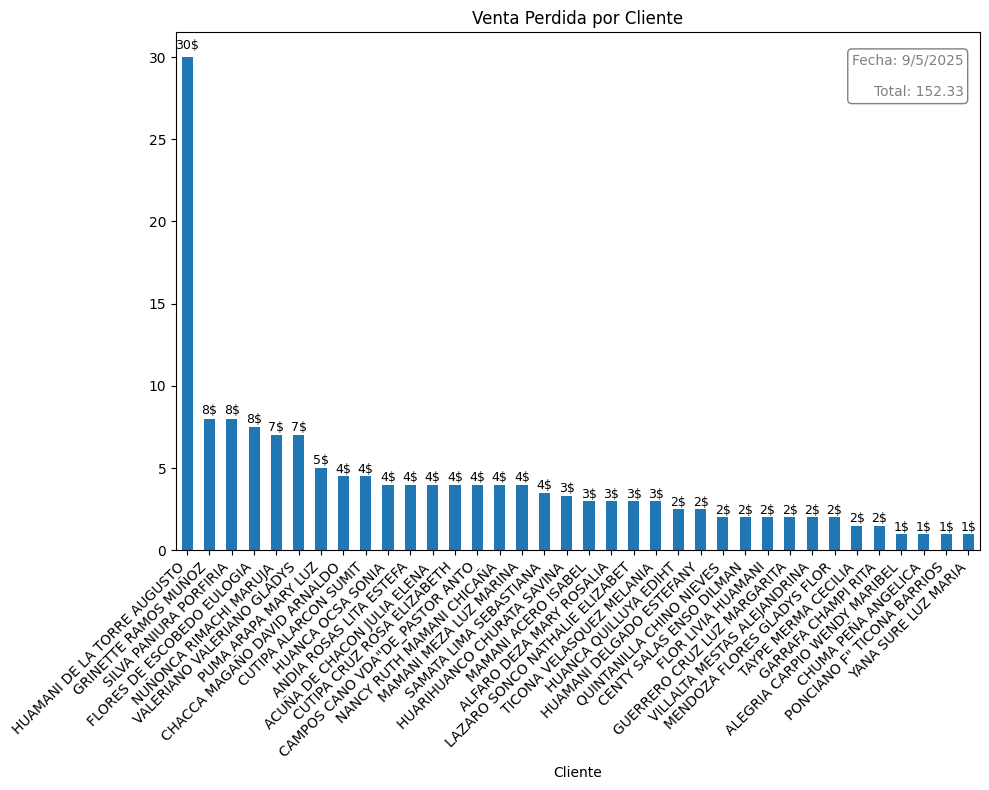

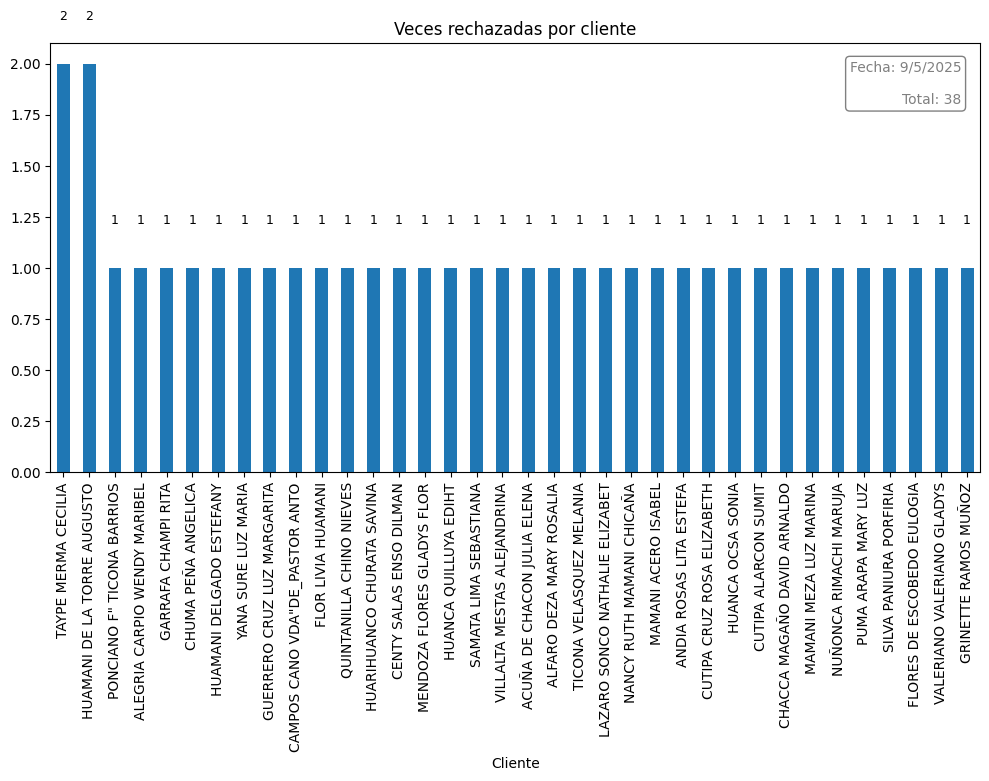

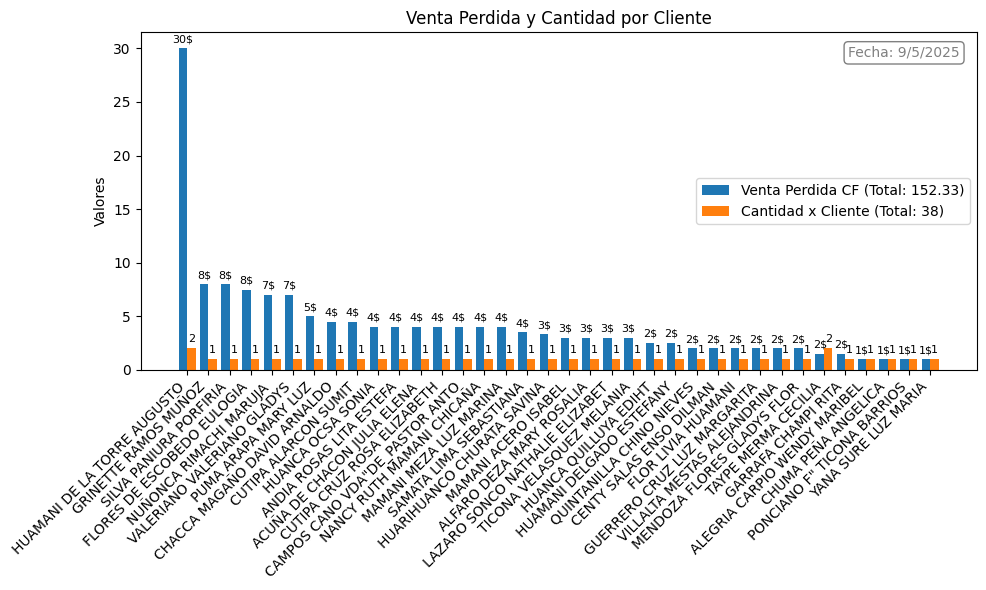

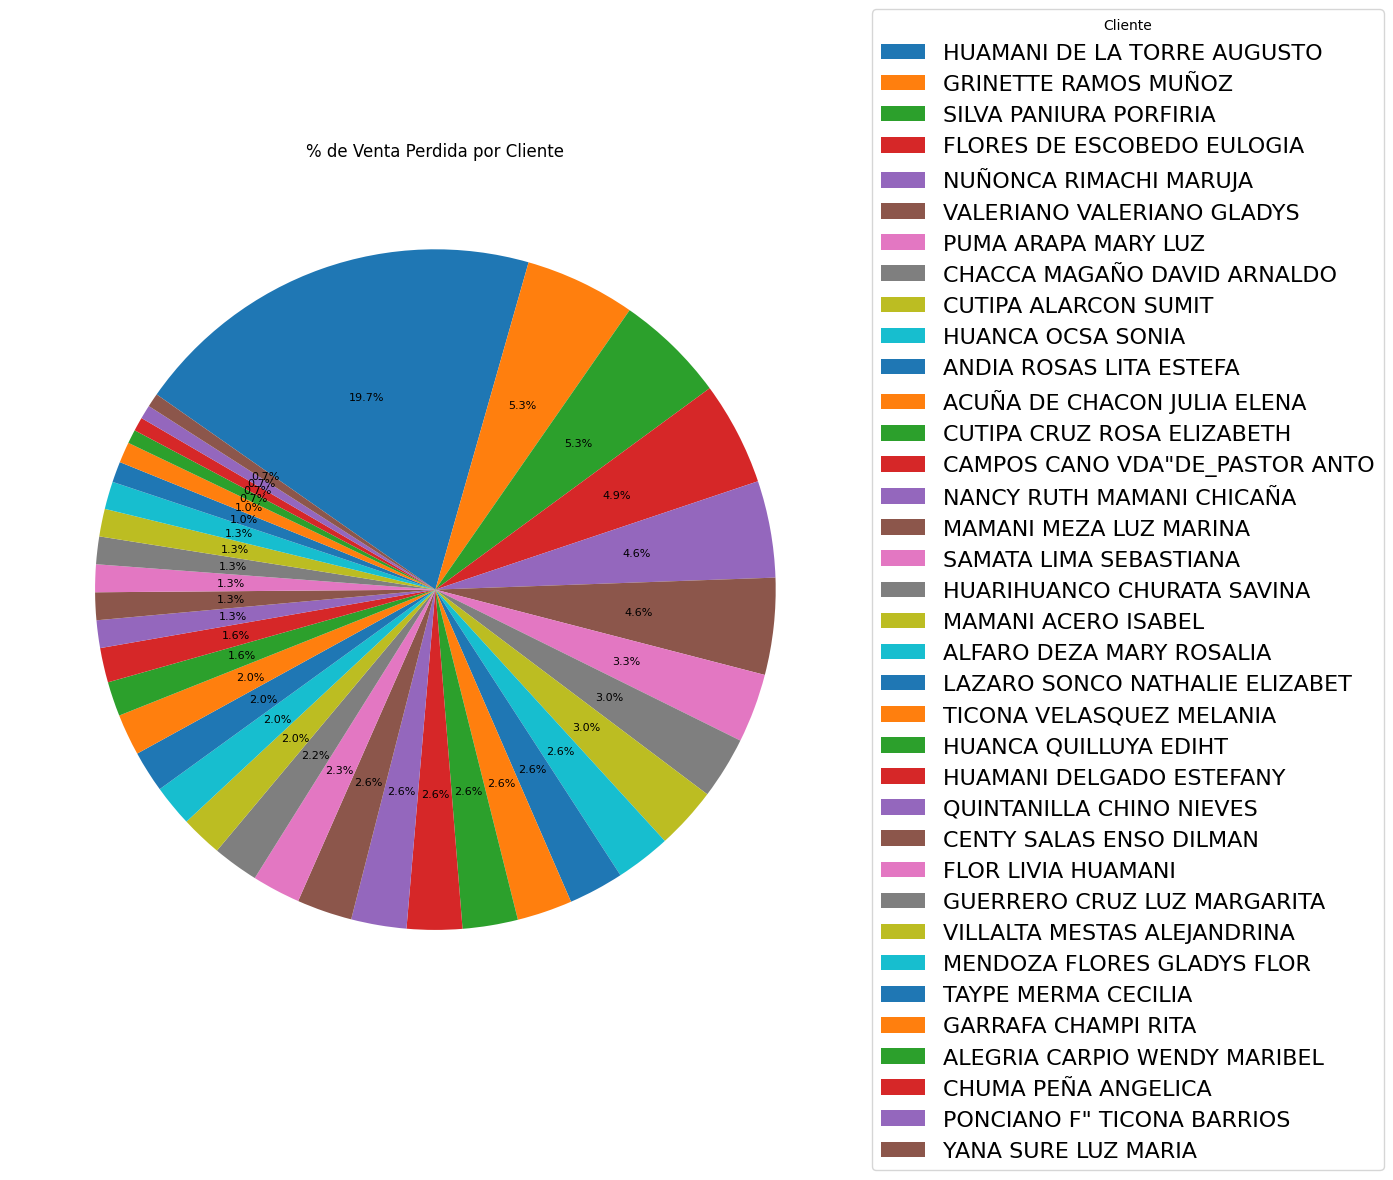

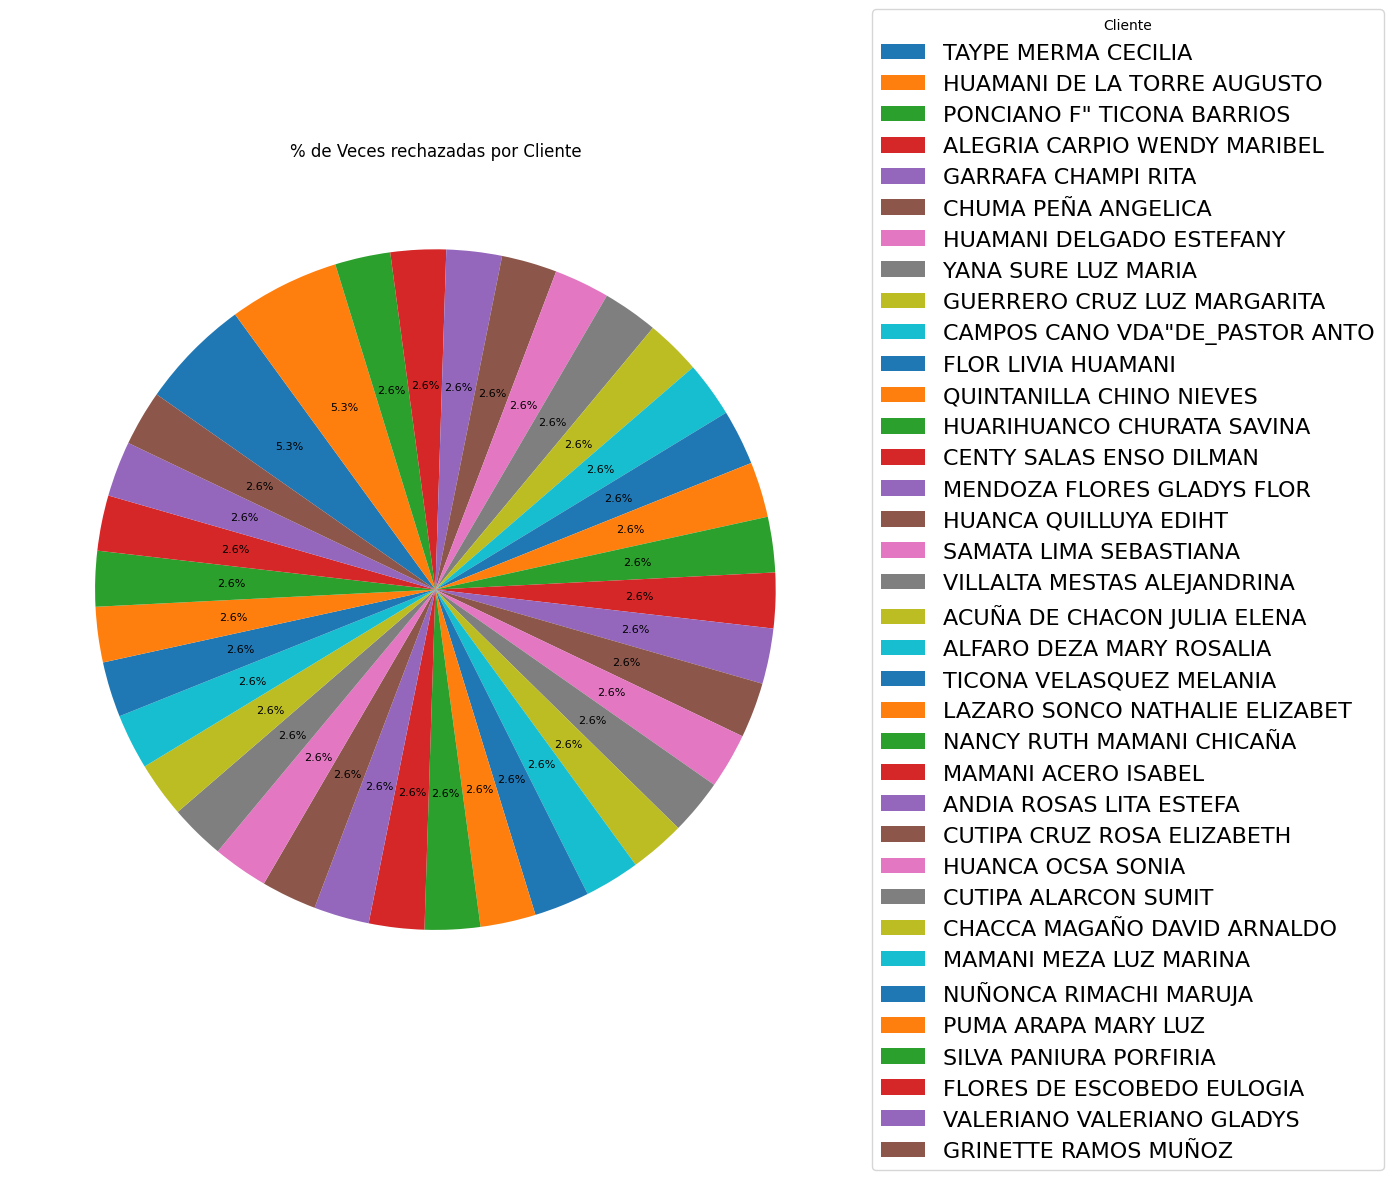

CONFIGURACION --------------------
Tiempo: Por Día
Tipo de analisis: Por Categoria


In [ ]:
''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por Venta Perdida
(2) Por Veces Rechazadas
(3) Por Venta Perdida y Veces Rechazadas
(4) Por Venta Perdida (Porcentual)
(5) Por Veces Rechazadas (Porcentual)
(6) Por Categoria
(7) 
'''

# Seleccionar la opcion_tipo de análisis por tiempo
opcion_tipo = int(input("(1=VP) (2=VC) (3=VPyVC) (4=VP%) (5=VC%) (6=Categoria)"))

if opcion_tipo == 1:
    vp_motivo_anulacion()
    vp_transportista()
    vp_ruta()
    vp_cliente()
    vp_vendedor()
    vp_locacion()

elif opcion_tipo == 2:
    vr_motivo_anulacion()
    vr_transportista()
    vr_ruta()
    vr_cliente()
    vr_vendedor()
    vr_locacion()

elif opcion_tipo == 3:
    vp_vr_motivo_anulacion()
    vp_vr_transportista()
    vp_vr_ruta()
    vp_vr_cliente()
    vp_vr_vendedor()
    vp_vr_locacion()

elif opcion_tipo == 4:
    vp_porcentual_motivo_anulacion()
    vp_porcentual_transportista()
    vp_porcentual_ruta()
    vp_porcentual_cliente()
    vp_porcentual_vendedor()
    vp_porcentual_locacion()

elif opcion_tipo == 5:
    vr_porcentual_motivo_anulacion()
    vr_porcentual_transportista()
    vr_porcentual_ruta()
    vr_porcentual_cliente()
    vr_porcentual_vendedor()
    vr_porcentual_locacion()

elif opcion_tipo == 6:
    opcion_categoria_dic = {
        1: 'motivo_anulacion',
        2: 'transportista',
        3: 'ruta',
        4: 'cliente',
        5: 'vendedor',
        6: 'locacion',
    }
    opcion_categoria = int(input("(1=Motivo) (2=Transportista) (3=Ruta) (4=Cliente) (5=Vendedor) (6=Locacion)"))
    eval(f'vp_{opcion_categoria_dic[opcion_categoria]}()')
    eval(f'vr_{opcion_categoria_dic[opcion_categoria]}()')
    eval(f'vp_vr_{opcion_categoria_dic[opcion_categoria]}()')
    eval(f'vp_porcentual_{opcion_categoria_dic[opcion_categoria]}()')
    eval(f'vr_porcentual_{opcion_categoria_dic[opcion_categoria]}()')

elif opcion_tipo == 7:
    print()

print('CONFIGURACION --------------------------------------')
opcion_tiempo_dic = {
    1: 'Por Año',
    2: 'Por Mes',
    3: 'Por Día',
    4: 'Intervalo',
    5: 'Mayor igual que',
}
opcion_tipo_dic = {
    1: 'Por Venta Perdida',
    2: 'Por Veces Rechazadas',
    3: 'Por Venta Perdida y Veces Rechazadas',
    4: 'Por Venta Perdida (Porcentual)',
    5: 'Por Veces Rechazadas (Porcentual)',
    6: 'Por Categoria',
    7: ''
}
print(f'Tiempo: {opcion_tiempo_dic[opcion_tiempo]}: {fecha}')
print(f'Tipo de analisis: {opcion_tipo_dic[opcion_tipo]}')